# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=30,
        fold=2,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_12-44-19/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192008 [00:00<?, ?it/s]

  0%|          | 0/21405 [00:00<?, ?it/s]

  0%|          | 0/53239 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192008 [00:00<?, ?it/s]

  0%|          | 0/53239 [00:00<?, ?it/s]

  0%|          | 0/21405 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.5146 | MulticlassF1Score=0.1076
Batch-30 : CrossEntropyLoss=2.4809 | MulticlassF1Score=0.1826
Batch-45 : CrossEntropyLoss=2.4701 | MulticlassF1Score=0.2089
Batch-60 : CrossEntropyLoss=2.4547 | MulticlassF1Score=0.2211
Batch-75 : CrossEntropyLoss=2.4785 | MulticlassF1Score=0.2373
Batch-90 : CrossEntropyLoss=2.4307 | MulticlassF1Score=0.2623
Batch-105: CrossEntropyLoss=2.4060 | MulticlassF1Score=0.2913
Batch-120: CrossEntropyLoss=2.3997 | MulticlassF1Score=0.3147
Batch-135: CrossEntropyLoss=2.3597 | MulticlassF1Score=0.3424
Batch-150: CrossEntropyLoss=2.3636 | MulticlassF1Score=0.3733
Batch-165: CrossEntropyLoss=2.3538 | MulticlassF1Score=0.4001
Batch-180: CrossEntropyLoss=2.3348 | MulticlassF1Score=0.4225
Batch-195: CrossEntropyLoss=2.3452 | MulticlassF1Score=0.4418
Batch-210: CrossEntropyLoss=2.3599 | MulticlassF1Score=0.4583
Batch-225: CrossEntropyLoss=2.3595 | MulticlassF1Score=0.4731
Batch-226: CrossEntropyLoss=2.3574 | MulticlassF1Score=0.4738

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3461 | MulticlassF1Score=0.6842
Batch-30 : CrossEntropyLoss=2.3341 | MulticlassF1Score=0.6791
Batch-45 : CrossEntropyLoss=2.3510 | MulticlassF1Score=0.6764
Batch-60 : CrossEntropyLoss=2.3438 | MulticlassF1Score=0.6762
Batch-63 : CrossEntropyLoss=2.3570 | MulticlassF1Score=0.6761

Training   : Mean CrossEntropyLoss = 2.4198 | Mean MulticlassF1Score = 0.3024
Validation : Mean CrossEntropyLoss = 2.3485 | Mean MulticlassF1Score = 0.6779

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3510 | MulticlassF1Score=0.6776
Batch-30 : CrossEntropyLoss=2.3404 | MulticlassF1Score=0.6841
Batch-45 : CrossEntropyLoss=2.3153 | MulticlassF1Score=0.7067
Batch-60 : CrossEntropyLoss=2.3171 | MulticlassF1Score=0.7225
Batch-75 : CrossEntropyLoss=2.3179 | MulticlassF1Score=0.7339
Batch-90 : CrossEntropyLoss=2.3305 | MulticlassF1Score=0.7419
Batch-105: CrossEntropyLoss=2.2994 | MulticlassF1Score=0.7481
Batch-120: CrossEntropyLoss=2.3156 | MulticlassF1Score=0.7533
Batch-135: CrossEntropyLoss=2.3034 | MulticlassF1Score=0.7580
Batch-150: CrossEntropyLoss=2.3094 | MulticlassF1Score=0.7605
Batch-165: CrossEntropyLoss=2.3143 | MulticlassF1Score=0.7634
Batch-180: CrossEntropyLoss=2.3231 | MulticlassF1Score=0.7653
Batch-195: CrossEntropyLoss=2.3136 | MulticlassF1Score=0.7671
Batch-210: CrossEntropyLoss=2.3181 | MulticlassF1Score=0.7682
Batch-225: CrossEntropyLoss=2.3096 | MulticlassF1Score=0.7694
Batch-226: CrossEntropyLoss=2.3128 | MulticlassF1Score=0.7695

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3125 | MulticlassF1Score=0.7924
Batch-30 : CrossEntropyLoss=2.3109 | MulticlassF1Score=0.7963
Batch-45 : CrossEntropyLoss=2.3174 | MulticlassF1Score=0.7938
Batch-60 : CrossEntropyLoss=2.3133 | MulticlassF1Score=0.7906
Batch-63 : CrossEntropyLoss=2.3119 | MulticlassF1Score=0.7911

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3204 | Mean MulticlassF1Score = 0.7388
Validation : Mean CrossEntropyLoss = 2.3128 | Mean MulticlassF1Score = 0.7944

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3174 | MulticlassF1Score=0.7936
Batch-30 : CrossEntropyLoss=2.3157 | MulticlassF1Score=0.7917
Batch-45 : CrossEntropyLoss=2.3177 | MulticlassF1Score=0.7954
Batch-60 : CrossEntropyLoss=2.3317 | MulticlassF1Score=0.7917
Batch-75 : CrossEntropyLoss=2.3084 | MulticlassF1Score=0.7918
Batch-90 : CrossEntropyLoss=2.3121 | MulticlassF1Score=0.7919
Batch-105: CrossEntropyLoss=2.3046 | MulticlassF1Score=0.7918
Batch-120: CrossEntropyLoss=2.3048 | MulticlassF1Score=0.7923
Batch-135: CrossEntropyLoss=2.3183 | MulticlassF1Score=0.7924
Batch-150: CrossEntropyLoss=2.3057 | MulticlassF1Score=0.7929
Batch-165: CrossEntropyLoss=2.3049 | MulticlassF1Score=0.7931
Batch-180: CrossEntropyLoss=2.3066 | MulticlassF1Score=0.7935
Batch-195: CrossEntropyLoss=2.3086 | MulticlassF1Score=0.7936
Batch-210: CrossEntropyLoss=2.3182 | MulticlassF1Score=0.7942
Batch-225: CrossEntropyLoss=2.3144 | MulticlassF1Score=0.7942
Batch-226: CrossEntropyLoss=2.3230 | MulticlassF1Score=0.7941

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3211 | MulticlassF1Score=0.7927
Batch-30 : CrossEntropyLoss=2.3099 | MulticlassF1Score=0.7931
Batch-45 : CrossEntropyLoss=2.3115 | MulticlassF1Score=0.7941
Batch-60 : CrossEntropyLoss=2.3155 | MulticlassF1Score=0.7953
Batch-63 : CrossEntropyLoss=2.3187 | MulticlassF1Score=0.7945

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3118 | Mean MulticlassF1Score = 0.7931
Validation : Mean CrossEntropyLoss = 2.3115 | Mean MulticlassF1Score = 0.7928

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3103 | MulticlassF1Score=0.7933
Batch-30 : CrossEntropyLoss=2.3173 | MulticlassF1Score=0.7928
Batch-45 : CrossEntropyLoss=2.2975 | MulticlassF1Score=0.7929
Batch-60 : CrossEntropyLoss=2.3097 | MulticlassF1Score=0.7945
Batch-75 : CrossEntropyLoss=2.3137 | MulticlassF1Score=0.7942
Batch-90 : CrossEntropyLoss=2.3034 | MulticlassF1Score=0.7952
Batch-105: CrossEntropyLoss=2.3185 | MulticlassF1Score=0.7957
Batch-120: CrossEntropyLoss=2.3018 | MulticlassF1Score=0.7963
Batch-135: CrossEntropyLoss=2.3060 | MulticlassF1Score=0.7969
Batch-150: CrossEntropyLoss=2.3053 | MulticlassF1Score=0.7966
Batch-165: CrossEntropyLoss=2.3193 | MulticlassF1Score=0.7969
Batch-180: CrossEntropyLoss=2.3234 | MulticlassF1Score=0.7966
Batch-195: CrossEntropyLoss=2.3078 | MulticlassF1Score=0.7965
Batch-210: CrossEntropyLoss=2.3045 | MulticlassF1Score=0.7967
Batch-225: CrossEntropyLoss=2.3102 | MulticlassF1Score=0.7968
Batch-226: CrossEntropyLoss=2.3082 | MulticlassF1Score=0.7969

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3062 | MulticlassF1Score=0.7956
Batch-30 : CrossEntropyLoss=2.3103 | MulticlassF1Score=0.7939
Batch-45 : CrossEntropyLoss=2.3127 | MulticlassF1Score=0.7943
Batch-60 : CrossEntropyLoss=2.2963 | MulticlassF1Score=0.7961
Batch-63 : CrossEntropyLoss=2.3194 | MulticlassF1Score=0.7954

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3107 | Mean MulticlassF1Score = 0.7952
Validation : Mean CrossEntropyLoss = 2.3110 | Mean MulticlassF1Score = 0.7953

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3084 | MulticlassF1Score=0.8011
Batch-30 : CrossEntropyLoss=2.3190 | MulticlassF1Score=0.7988
Batch-45 : CrossEntropyLoss=2.3075 | MulticlassF1Score=0.7984
Batch-60 : CrossEntropyLoss=2.3078 | MulticlassF1Score=0.8004
Batch-75 : CrossEntropyLoss=2.3099 | MulticlassF1Score=0.8008
Batch-90 : CrossEntropyLoss=2.3117 | MulticlassF1Score=0.8019
Batch-105: CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8022
Batch-120: CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8035
Batch-135: CrossEntropyLoss=2.3138 | MulticlassF1Score=0.8041
Batch-150: CrossEntropyLoss=2.3083 | MulticlassF1Score=0.8044
Batch-165: CrossEntropyLoss=2.3077 | MulticlassF1Score=0.8051
Batch-180: CrossEntropyLoss=2.3084 | MulticlassF1Score=0.8051
Batch-195: CrossEntropyLoss=2.3037 | MulticlassF1Score=0.8054
Batch-210: CrossEntropyLoss=2.3065 | MulticlassF1Score=0.8055
Batch-225: CrossEntropyLoss=2.3037 | MulticlassF1Score=0.8057
Batch-226: CrossEntropyLoss=2.3054 | MulticlassF1Score=0.8057

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3160 | MulticlassF1Score=0.8062
Batch-30 : CrossEntropyLoss=2.3012 | MulticlassF1Score=0.8053
Batch-45 : CrossEntropyLoss=2.3096 | MulticlassF1Score=0.8075
Batch-60 : CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8076
Batch-63 : CrossEntropyLoss=2.3072 | MulticlassF1Score=0.8078

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3079 | Mean MulticlassF1Score = 0.8025
Validation : Mean CrossEntropyLoss = 2.3071 | Mean MulticlassF1Score = 0.8070

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3075 | MulticlassF1Score=0.8137
Batch-30 : CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8137
Batch-45 : CrossEntropyLoss=2.3101 | MulticlassF1Score=0.8114
Batch-60 : CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8118
Batch-75 : CrossEntropyLoss=2.3111 | MulticlassF1Score=0.8120
Batch-90 : CrossEntropyLoss=2.3047 | MulticlassF1Score=0.8125
Batch-105: CrossEntropyLoss=2.3148 | MulticlassF1Score=0.8126
Batch-120: CrossEntropyLoss=2.3181 | MulticlassF1Score=0.8117
Batch-135: CrossEntropyLoss=2.3047 | MulticlassF1Score=0.8120
Batch-150: CrossEntropyLoss=2.3025 | MulticlassF1Score=0.8115
Batch-165: CrossEntropyLoss=2.3025 | MulticlassF1Score=0.8122
Batch-180: CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8143
Batch-195: CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8168
Batch-210: CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8183
Batch-225: CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8200
Batch-226: CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8201

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8418
Batch-30 : CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8416
Batch-45 : CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8411
Batch-60 : CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8408
Batch-63 : CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8409

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3035 | Mean MulticlassF1Score = 0.8139
Validation : Mean CrossEntropyLoss = 2.2971 | Mean MulticlassF1Score = 0.8418

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8475
Batch-30 : CrossEntropyLoss=2.2942 | MulticlassF1Score=0.8479
Batch-45 : CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8477
Batch-60 : CrossEntropyLoss=2.2918 | MulticlassF1Score=0.8483
Batch-75 : CrossEntropyLoss=2.2983 | MulticlassF1Score=0.8485
Batch-90 : CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8489
Batch-105: CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8506
Batch-120: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8518
Batch-135: CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8520
Batch-150: CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8519
Batch-165: CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8526
Batch-180: CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8529
Batch-195: CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8534
Batch-210: CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8537
Batch-225: CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8535
Batch-226: CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8535

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8563
Batch-30 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8549
Batch-45 : CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8536
Batch-60 : CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8532
Batch-63 : CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8532

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2933 | Mean MulticlassF1Score = 0.8506
Validation : Mean CrossEntropyLoss = 2.2932 | Mean MulticlassF1Score = 0.8547

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8559
Batch-30 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8599
Batch-45 : CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8580
Batch-60 : CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8581
Batch-75 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8582
Batch-90 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8584
Batch-105: CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8592
Batch-120: CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8585
Batch-135: CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8570
Batch-150: CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8579
Batch-165: CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8579
Batch-180: CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8579
Batch-195: CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8581
Batch-210: CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8582
Batch-225: CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8583
Batch-226: CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8583

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8544
Batch-30 : CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8540
Batch-45 : CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8539
Batch-60 : CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8535
Batch-63 : CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8534

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2917 | Mean MulticlassF1Score = 0.8584
Validation : Mean CrossEntropyLoss = 2.2931 | Mean MulticlassF1Score = 0.8522

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8682
Batch-30 : CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8631
Batch-45 : CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8633
Batch-60 : CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8622
Batch-75 : CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8615
Batch-90 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8618
Batch-105: CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8614
Batch-120: CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8606
Batch-135: CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8603
Batch-150: CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8601
Batch-165: CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8599
Batch-180: CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8602
Batch-195: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8601
Batch-210: CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8593
Batch-225: CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8595
Batch-226: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8596

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8536
Batch-30 : CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8547
Batch-45 : CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8549
Batch-60 : CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8541
Batch-63 : CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8542

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2912 | Mean MulticlassF1Score = 0.8615
Validation : Mean CrossEntropyLoss = 2.2927 | Mean MulticlassF1Score = 0.8536

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8583
Batch-30 : CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8587
Batch-45 : CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8590
Batch-60 : CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8609
Batch-75 : CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8612
Batch-90 : CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8637
Batch-105: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8663
Batch-120: CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8693
Batch-135: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8709
Batch-150: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8727
Batch-165: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.8742
Batch-180: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8752
Batch-195: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8762
Batch-210: CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8769
Batch-225: CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8778
Batch-226: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8779

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8757
Batch-30 : CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8794
Batch-45 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8798
Batch-60 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8818
Batch-63 : CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8816

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2857 | Mean MulticlassF1Score = 0.8673
Validation : Mean CrossEntropyLoss = 2.2844 | Mean MulticlassF1Score = 0.8782

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8924
Batch-30 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8905
Batch-45 : CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8918
Batch-60 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8928
Batch-75 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.8922
Batch-90 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8928
Batch-105: CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8924
Batch-120: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8924
Batch-135: CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8924
Batch-150: CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8921
Batch-165: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.8924
Batch-180: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8921
Batch-195: CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8917
Batch-210: CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8916
Batch-225: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8916
Batch-226: CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8915

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8886
Batch-30 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8851
Batch-45 : CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8842
Batch-60 : CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8835
Batch-63 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.8837

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2814 | Mean MulticlassF1Score = 0.8915
Validation : Mean CrossEntropyLoss = 2.2836 | Mean MulticlassF1Score = 0.8865

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8946
Batch-30 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.8947
Batch-45 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8921
Batch-60 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.8937
Batch-75 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8934
Batch-90 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8932
Batch-105: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.8938
Batch-120: CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8938
Batch-135: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8935
Batch-150: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8938
Batch-165: CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8940
Batch-180: CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8939
Batch-195: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.8939
Batch-210: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.8940
Batch-225: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8940
Batch-226: CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8939

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8844
Batch-30 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8839
Batch-45 : CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8835
Batch-60 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8842
Batch-63 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8843

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2806 | Mean MulticlassF1Score = 0.8935
Validation : Mean CrossEntropyLoss = 2.2835 | Mean MulticlassF1Score = 0.8833

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8978
Batch-30 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8950
Batch-45 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.8964
Batch-60 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8971
Batch-75 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8962
Batch-90 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.8961
Batch-105: CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8963
Batch-120: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8961
Batch-135: CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8959
Batch-150: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8958
Batch-165: CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8959
Batch-180: CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8955
Batch-195: CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8960
Batch-210: CrossEntropyLoss=2.2763 | MulticlassF1Score=0.8957
Batch-225: CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8957
Batch-226: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.8958

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8824
Batch-30 : CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8847
Batch-45 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8841
Batch-60 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8854
Batch-63 : CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8854

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2799 | Mean MulticlassF1Score = 0.8961
Validation : Mean CrossEntropyLoss = 2.2831 | Mean MulticlassF1Score = 0.8834

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.8953
Batch-30 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8976
Batch-45 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8983
Batch-60 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.8968
Batch-75 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.8971
Batch-90 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8967
Batch-105: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8969
Batch-120: CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8966
Batch-135: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8966
Batch-150: CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8969
Batch-165: CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8972
Batch-180: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8972
Batch-195: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8972
Batch-210: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8970
Batch-225: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8970
Batch-226: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.8970

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8849
Batch-30 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8830
Batch-45 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8847
Batch-60 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.8851
Batch-63 : CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8859

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2795 | Mean MulticlassF1Score = 0.8969
Validation : Mean CrossEntropyLoss = 2.2830 | Mean MulticlassF1Score = 0.8845

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8947
Batch-30 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8975
Batch-45 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.8993
Batch-60 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8987
Batch-75 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.8989
Batch-90 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.8991
Batch-105: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.8994
Batch-120: CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8987
Batch-135: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8989
Batch-150: CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8989
Batch-165: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8983
Batch-180: CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8978
Batch-195: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.8983
Batch-210: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8984
Batch-225: CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8985
Batch-226: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8984

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8870
Batch-30 : CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8864
Batch-45 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8855
Batch-60 : CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8854
Batch-63 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8858

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2791 | Mean MulticlassF1Score = 0.8981
Validation : Mean CrossEntropyLoss = 2.2828 | Mean MulticlassF1Score = 0.8854

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.8990
Batch-30 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8995
Batch-45 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.9009
Batch-60 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.9004
Batch-75 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9002
Batch-90 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.8999
Batch-105: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.9001
Batch-120: CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8999
Batch-135: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.9000
Batch-150: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9003
Batch-165: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.9002
Batch-180: CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8999
Batch-195: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.8999
Batch-210: CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8997
Batch-225: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.8996
Batch-226: CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8996

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8814
Batch-30 : CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8839
Batch-45 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8853
Batch-60 : CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8861
Batch-63 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.8869

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2786 | Mean MulticlassF1Score = 0.9000
Validation : Mean CrossEntropyLoss = 2.2825 | Mean MulticlassF1Score = 0.8843

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.9009
Batch-30 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8997
Batch-45 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9000
Batch-60 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8997
Batch-75 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8998
Batch-90 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9001
Batch-105: CrossEntropyLoss=2.2790 | MulticlassF1Score=0.9002
Batch-120: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9004
Batch-135: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9008
Batch-150: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9009
Batch-165: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.9004
Batch-180: CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9007
Batch-195: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9009
Batch-210: CrossEntropyLoss=2.2853 | MulticlassF1Score=0.9006
Batch-225: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9002
Batch-226: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9002

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8911
Batch-30 : CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8889
Batch-45 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8874
Batch-60 : CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8866
Batch-63 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8869

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2784 | Mean MulticlassF1Score = 0.9005
Validation : Mean CrossEntropyLoss = 2.2825 | Mean MulticlassF1Score = 0.8894

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9049
Batch-30 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.9015
Batch-45 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8993
Batch-60 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8991
Batch-75 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.9000
Batch-90 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9004
Batch-105: CrossEntropyLoss=2.2865 | MulticlassF1Score=0.9002
Batch-120: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9003
Batch-135: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.9003
Batch-150: CrossEntropyLoss=2.2806 | MulticlassF1Score=0.9008
Batch-165: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9007
Batch-180: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9009
Batch-195: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9007
Batch-210: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9009
Batch-225: CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9009
Batch-226: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9009

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8869
Batch-30 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8862
Batch-45 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8859
Batch-60 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8868
Batch-63 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8872

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2782 | Mean MulticlassF1Score = 0.9011
Validation : Mean CrossEntropyLoss = 2.2825 | Mean MulticlassF1Score = 0.8853

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.8983
Batch-30 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9007
Batch-45 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.9016
Batch-60 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9020
Batch-75 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9010
Batch-90 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9015
Batch-105: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9018
Batch-120: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9016
Batch-135: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9016
Batch-150: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9014
Batch-165: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9017
Batch-180: CrossEntropyLoss=2.2823 | MulticlassF1Score=0.9016
Batch-195: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9019
Batch-210: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9019
Batch-225: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9022
Batch-226: CrossEntropyLoss=2.2827 | MulticlassF1Score=0.9021

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8900
Batch-30 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8901
Batch-45 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8890
Batch-60 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.8893
Batch-63 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8896

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2778 | Mean MulticlassF1Score = 0.9012
Validation : Mean CrossEntropyLoss = 2.2817 | Mean MulticlassF1Score = 0.8906

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9078
Batch-30 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9078
Batch-45 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9069
Batch-60 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9070
Batch-75 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.9060
Batch-90 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.9053
Batch-105: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9049
Batch-120: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9055
Batch-135: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9058
Batch-150: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9061
Batch-165: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9059
Batch-180: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9057
Batch-195: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9056
Batch-210: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9058
Batch-225: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9058
Batch-226: CrossEntropyLoss=2.2856 | MulticlassF1Score=0.9057

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8886
Batch-30 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.8905
Batch-45 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8915
Batch-60 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8912
Batch-63 : CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8909

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2767 | Mean MulticlassF1Score = 0.9059
Validation : Mean CrossEntropyLoss = 2.2813 | Mean MulticlassF1Score = 0.8899

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9047
Batch-30 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9073
Batch-45 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9061
Batch-60 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9067
Batch-75 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9070
Batch-90 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9068
Batch-105: CrossEntropyLoss=2.2805 | MulticlassF1Score=0.9067
Batch-120: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9068
Batch-135: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9071
Batch-150: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9073
Batch-165: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9070
Batch-180: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.9071
Batch-195: CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9067
Batch-210: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9070
Batch-225: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9070
Batch-226: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9070

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8914
Batch-30 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8902
Batch-45 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8908
Batch-60 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8915
Batch-63 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8911

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2763 | Mean MulticlassF1Score = 0.9067
Validation : Mean CrossEntropyLoss = 2.2812 | Mean MulticlassF1Score = 0.8917

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.9076
Batch-30 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9099
Batch-45 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9088
Batch-60 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9089
Batch-75 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9081
Batch-90 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9086
Batch-105: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9081
Batch-120: CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9081
Batch-135: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9079
Batch-150: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.9077
Batch-165: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9078
Batch-180: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9079
Batch-195: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9079
Batch-210: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9080
Batch-225: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9079
Batch-226: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9079

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8911
Batch-30 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8910
Batch-45 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.8915
Batch-60 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.8913
Batch-63 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8912

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2760 | Mean MulticlassF1Score = 0.9084
Validation : Mean CrossEntropyLoss = 2.2812 | Mean MulticlassF1Score = 0.8917

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9060
Batch-30 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9060
Batch-45 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9066
Batch-60 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9075
Batch-75 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.9066
Batch-90 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9066
Batch-105: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9076
Batch-120: CrossEntropyLoss=2.2815 | MulticlassF1Score=0.9077
Batch-135: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.9077
Batch-150: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9080
Batch-165: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9091
Batch-180: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9112
Batch-195: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9129
Batch-210: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9147
Batch-225: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9159
Batch-226: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9160

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.9192
Batch-30 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9196
Batch-45 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9203
Batch-60 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9199
Batch-63 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9199

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2736 | Mean MulticlassF1Score = 0.9086
Validation : Mean CrossEntropyLoss = 2.2727 | Mean MulticlassF1Score = 0.9200

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9346
Batch-30 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9369
Batch-45 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9367
Batch-60 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9371
Batch-75 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9377
Batch-90 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9373
Batch-105: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9376
Batch-120: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9375
Batch-135: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9375
Batch-150: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9374
Batch-165: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9376
Batch-180: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9376
Batch-195: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9377
Batch-210: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9379
Batch-225: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9378
Batch-226: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9378

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9250
Batch-30 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9227
Batch-45 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9223
Batch-60 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9220
Batch-63 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9221

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2670 | Mean MulticlassF1Score = 0.9370
Validation : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9229

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9356
Batch-30 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9372
Batch-45 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9389
Batch-60 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9396
Batch-75 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9395
Batch-90 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9396
Batch-105: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9398
Batch-120: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9400
Batch-135: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9395
Batch-150: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9396
Batch-165: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9396
Batch-180: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9394
Batch-195: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9393
Batch-210: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9393
Batch-225: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9393
Batch-226: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9393

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9240
Batch-30 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9236
Batch-45 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9246
Batch-60 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9234
Batch-63 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9228

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2663 | Mean MulticlassF1Score = 0.9389
Validation : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9245

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9390
Batch-30 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9403
Batch-45 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9402
Batch-60 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9402
Batch-75 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9407
Batch-90 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9406
Batch-105: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9402
Batch-120: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9400
Batch-135: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9399
Batch-150: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9399
Batch-165: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9399
Batch-180: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9402
Batch-195: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9400
Batch-210: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9400
Batch-225: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9401
Batch-226: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9401

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9240
Batch-30 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9238
Batch-45 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9215
Batch-60 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9228
Batch-63 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9225

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2661 | Mean MulticlassF1Score = 0.9400
Validation : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9229

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9414
Batch-30 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9393
Batch-45 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9403
Batch-60 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9412
Batch-75 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9415
Batch-90 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9414
Batch-105: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9412
Batch-120: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9412
Batch-135: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9416
Batch-150: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9410
Batch-165: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9405
Batch-180: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9404
Batch-195: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9405
Batch-210: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9406
Batch-225: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9405
Batch-226: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9405

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9217
Batch-30 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9210
Batch-45 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9216
Batch-60 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9230
Batch-63 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9232

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2659 | Mean MulticlassF1Score = 0.9407
Validation : Mean CrossEntropyLoss = 2.2713 | Mean MulticlassF1Score = 0.9216

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9388
Batch-30 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9392
Batch-45 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9407
Batch-60 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9407
Batch-75 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9413
Batch-90 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9412
Batch-105: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9411
Batch-120: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9410
Batch-135: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9409
Batch-150: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9408
Batch-165: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9403
Batch-180: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9406
Batch-195: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9408
Batch-210: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9406
Batch-225: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9408
Batch-226: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9408

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9232
Batch-30 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9233
Batch-45 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9234
Batch-60 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9231
Batch-63 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9229

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2658 | Mean MulticlassF1Score = 0.9404
Validation : Mean CrossEntropyLoss = 2.2713 | Mean MulticlassF1Score = 0.9234

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9426
Batch-30 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9420
Batch-45 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9424
Batch-60 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9423
Batch-75 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9420
Batch-90 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9417
Batch-105: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9417
Batch-120: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9416
Batch-135: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9413
Batch-150: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9412
Batch-165: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9414
Batch-180: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9419
Batch-195: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9419
Batch-210: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9415
Batch-225: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9414
Batch-226: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9414

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9212
Batch-30 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9215
Batch-45 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9233
Batch-60 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9230
Batch-63 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9227

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2656 | Mean MulticlassF1Score = 0.9418
Validation : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9222

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9440
Batch-30 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9440
Batch-45 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9422
Batch-60 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9414
Batch-75 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9415
Batch-90 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9425
Batch-105: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9431
Batch-120: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9432
Batch-135: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9434
Batch-150: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9437
Batch-165: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9437
Batch-180: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9437
Batch-195: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9438
Batch-210: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9441
Batch-225: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9441
Batch-226: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9440

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9288
Batch-30 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9276
Batch-45 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9275
Batch-60 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9270
Batch-63 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9270

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9432
Validation : Mean CrossEntropyLoss = 2.2702 | Mean MulticlassF1Score = 0.9266

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9487
Batch-30 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9485
Batch-45 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9471
Batch-60 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9467
Batch-75 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9468
Batch-90 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9471
Batch-105: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9468
Batch-120: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9468
Batch-135: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9464
Batch-150: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9465
Batch-165: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9464
Batch-180: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9464
Batch-195: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9467
Batch-210: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9466
Batch-225: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9465
Batch-226: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9464

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9262
Batch-30 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9270
Batch-45 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9282
Batch-60 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9279
Batch-63 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9276

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9471
Validation : Mean CrossEntropyLoss = 2.2700 | Mean MulticlassF1Score = 0.9265

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9459
Batch-30 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9460
Batch-45 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9469
Batch-60 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9472
Batch-75 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9468
Batch-90 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9471
Batch-105: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9472
Batch-120: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9471
Batch-135: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9469
Batch-150: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9470
Batch-165: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9471
Batch-180: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9471
Batch-195: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9468
Batch-210: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9469
Batch-225: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9468
Batch-226: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9467

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9273
Batch-30 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9307
Batch-45 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9289
Batch-60 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9282
Batch-63 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9286

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9468
Validation : Mean CrossEntropyLoss = 2.2697 | Mean MulticlassF1Score = 0.9294

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9457
Batch-30 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9480
Batch-45 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9468
Batch-60 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9474
Batch-75 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9471
Batch-90 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9467
Batch-105: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9471
Batch-120: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9473
Batch-135: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9475
Batch-150: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9468
Batch-165: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9471
Batch-180: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9470
Batch-195: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9472
Batch-210: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9472
Batch-225: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9475
Batch-226: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9474

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9320
Batch-30 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9297
Batch-45 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9290
Batch-60 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9287
Batch-63 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9284

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9470
Validation : Mean CrossEntropyLoss = 2.2696 | Mean MulticlassF1Score = 0.9297

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9488
Batch-30 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9514
Batch-45 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9547
Batch-60 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9576
Batch-75 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9594
Batch-90 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9610
Batch-105: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9617
Batch-120: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9622
Batch-135: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9628
Batch-150: CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9636
Batch-165: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9635
Batch-180: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9635
Batch-195: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9636
Batch-210: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9639
Batch-225: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9642
Batch-226: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9642

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9459
Batch-30 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9494
Batch-45 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9487
Batch-60 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9484
Batch-63 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9481

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2587 | Mean MulticlassF1Score = 0.9597
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9481

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9687
Batch-30 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9696
Batch-45 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9679
Batch-60 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9674
Batch-75 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9680
Batch-90 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9680
Batch-105: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9683
Batch-120: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9681
Batch-135: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9682
Batch-150: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9684
Batch-165: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9683
Batch-180: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9683
Batch-195: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9683
Batch-210: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9682
Batch-225: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9682
Batch-226: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9681

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9473
Batch-30 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9482
Batch-45 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9487
Batch-60 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9482
Batch-63 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9484

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2574 | Mean MulticlassF1Score = 0.9682
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9484

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9702
Batch-30 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9695
Batch-45 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9697
Batch-60 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9697
Batch-75 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9695
Batch-90 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9692
Batch-105: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9690
Batch-120: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9689
Batch-135: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9687
Batch-150: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9684
Batch-165: CrossEntropyLoss=2.2514 | MulticlassF1Score=0.9685
Batch-180: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9685
Batch-195: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9688
Batch-210: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9687
Batch-225: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9685
Batch-226: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9685

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9479
Batch-30 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9487
Batch-45 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9490
Batch-60 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9490
Batch-63 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9492

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2572 | Mean MulticlassF1Score = 0.9691
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9487

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9693
Batch-30 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9703
Batch-45 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9702
Batch-60 : CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9705
Batch-75 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9704
Batch-90 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9700
Batch-105: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9700
Batch-120: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9696
Batch-135: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9692
Batch-150: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9689
Batch-165: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9692
Batch-180: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9694
Batch-195: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9690
Batch-210: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9690
Batch-225: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9689
Batch-226: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9689

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9522
Batch-30 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9493
Batch-45 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9494
Batch-60 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9483
Batch-63 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9481

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9696
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9505

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9689
Batch-30 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9690
Batch-45 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9691
Batch-60 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9699
Batch-75 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9701
Batch-90 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9696
Batch-105: CrossEntropyLoss=2.2527 | MulticlassF1Score=0.9694
Batch-120: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9695
Batch-135: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9692
Batch-150: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9691
Batch-165: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9690
Batch-180: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9691
Batch-195: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9690
Batch-210: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9691
Batch-225: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9692
Batch-226: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9692

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9492
Batch-30 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9501
Batch-45 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9498
Batch-60 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9492
Batch-63 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9490

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9694
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9491

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9707
Batch-30 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9706
Batch-45 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9706
Batch-60 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9709
Batch-75 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9710
Batch-90 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9705
Batch-105: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9702
Batch-120: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9697
Batch-135: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9698
Batch-150: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9698
Batch-165: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9693
Batch-180: CrossEntropyLoss=2.2525 | MulticlassF1Score=0.9694
Batch-195: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9694
Batch-210: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9696
Batch-225: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9696
Batch-226: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9696

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9518
Batch-30 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9505
Batch-45 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9502
Batch-60 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9495
Batch-63 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9498

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9701
Validation : Mean CrossEntropyLoss = 2.2631 | Mean MulticlassF1Score = 0.9505

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9682
Batch-30 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9708
Batch-45 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9709
Batch-60 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9710
Batch-75 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9708
Batch-90 : CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9705
Batch-105: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9702
Batch-120: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9701
Batch-135: CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9701
Batch-150: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9700
Batch-165: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9703
Batch-180: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9699
Batch-195: CrossEntropyLoss=2.2515 | MulticlassF1Score=0.9700
Batch-210: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9700
Batch-225: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9699
Batch-226: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9699

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9504
Batch-30 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9507
Batch-45 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9494
Batch-60 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9488
Batch-63 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9492

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2568 | Mean MulticlassF1Score = 0.9701
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9501

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9679
Batch-30 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9693
Batch-45 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9692
Batch-60 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9698
Batch-75 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9697
Batch-90 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9692
Batch-105: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9692
Batch-120: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9696
Batch-135: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9698
Batch-150: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9701
Batch-165: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9702
Batch-180: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9702
Batch-195: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9701
Batch-210: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9700
Batch-225: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9701
Batch-226: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9700

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9490
Batch-30 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9472
Batch-45 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9473
Batch-60 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9491
Batch-63 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9491

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2567 | Mean MulticlassF1Score = 0.9695
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9480

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9680
Batch-30 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9685
Batch-45 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9693
Batch-60 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9701
Batch-75 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9705
Batch-90 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9706
Batch-105: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9705
Batch-120: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9702
Batch-135: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9704
Batch-150: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9703
Batch-165: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9701
Batch-180: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9700
Batch-195: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9699
Batch-210: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9697
Batch-225: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9699
Batch-226: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9698

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9460
Batch-30 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9479
Batch-45 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9494
Batch-60 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9496
Batch-63 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9495

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2568 | Mean MulticlassF1Score = 0.9698
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9484
Patience = 1/50❗

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9703
Batch-30 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9710
Batch-45 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9716
Batch-60 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9710
Batch-75 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9704
Batch-90 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9703
Batch-105: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9704
Batch-120: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9705
Batch-135: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9708
Batch-150: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9708
Batch-165: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9705
Batch-180: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9705
Batch-195: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9703
Batch-210: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9703
Batch-225: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9704
Batch-226: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9704

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9503
Batch-30 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9484
Batch-45 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9485
Batch-60 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9486
Batch-63 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9489

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2566 | Mean MulticlassF1Score = 0.9706
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9488

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9724
Batch-30 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9713
Batch-45 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9713
Batch-60 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9707
Batch-75 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9706
Batch-90 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9711
Batch-105: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9711
Batch-120: CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9713
Batch-135: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9711
Batch-150: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9711
Batch-165: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9709
Batch-180: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9709
Batch-195: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9710
Batch-210: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9711
Batch-225: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9710
Batch-226: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9709

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9532
Batch-30 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9516
Batch-45 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9511
Batch-60 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9495
Batch-63 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9498

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2564 | Mean MulticlassF1Score = 0.9711
Validation : Mean CrossEntropyLoss = 2.2631 | Mean MulticlassF1Score = 0.9521

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9716
Batch-30 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9720
Batch-45 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9718
Batch-60 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9715
Batch-75 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9716
Batch-90 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9716
Batch-105: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9716
Batch-120: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9716
Batch-135: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9715
Batch-150: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9713
Batch-165: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9710
Batch-180: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9707
Batch-195: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9708
Batch-210: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9708
Batch-225: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9708
Batch-226: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9708

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9471
Batch-30 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9501
Batch-45 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9496
Batch-60 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9494
Batch-63 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9495

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2564 | Mean MulticlassF1Score = 0.9712
Validation : Mean CrossEntropyLoss = 2.2631 | Mean MulticlassF1Score = 0.9491
Patience = 2/50❗

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9712
Batch-30 : CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9706
Batch-45 : CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9710
Batch-60 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9707
Batch-75 : CrossEntropyLoss=2.2520 | MulticlassF1Score=0.9714
Batch-90 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9710
Batch-105: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9712
Batch-120: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9713
Batch-135: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9717
Batch-150: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9714
Batch-165: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9714
Batch-180: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9712
Batch-195: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9713
Batch-210: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9713
Batch-225: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9712
Batch-226: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9713

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9516
Batch-30 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9513
Batch-45 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9503
Batch-60 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9497
Batch-63 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9494

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2563 | Mean MulticlassF1Score = 0.9711
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9509

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9708
Batch-30 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9704
Batch-45 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9704
Batch-60 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9712
Batch-75 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9713
Batch-90 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9717
Batch-105: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9716
Batch-120: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9715
Batch-135: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9716
Batch-150: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9714
Batch-165: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9711
Batch-180: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9710
Batch-195: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9711
Batch-210: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9711
Batch-225: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9712
Batch-226: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9712

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9481
Batch-30 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9476
Batch-45 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9482
Batch-60 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9489
Batch-63 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9491

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2564 | Mean MulticlassF1Score = 0.9711
Validation : Mean CrossEntropyLoss = 2.2631 | Mean MulticlassF1Score = 0.9485
Patience = 3/50❗

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9704
Batch-30 : CrossEntropyLoss=2.2521 | MulticlassF1Score=0.9720
Batch-45 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9717
Batch-60 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9714
Batch-75 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9710
Batch-90 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9711
Batch-105: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9712
Batch-120: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9712
Batch-135: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9711
Batch-150: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9710
Batch-165: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9711
Batch-180: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9714
Batch-195: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9714
Batch-210: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9713
Batch-225: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9713
Batch-226: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9713

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9518
Batch-30 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9481
Batch-45 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9490
Batch-60 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9495
Batch-63 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9490

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2563 | Mean MulticlassF1Score = 0.9711
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9497

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9702
Batch-30 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9710
Batch-45 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9704
Batch-60 : CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9724
Batch-75 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9722
Batch-90 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9721
Batch-105: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9718
Batch-120: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9714
Batch-135: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9715
Batch-150: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9715
Batch-165: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9716
Batch-180: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9716
Batch-195: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9717
Batch-210: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9714
Batch-225: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9715
Batch-226: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9715

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9521
Batch-30 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9497
Batch-45 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9495
Batch-60 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9488
Batch-63 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9488

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2562 | Mean MulticlassF1Score = 0.9714
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9503

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9723
Batch-30 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9716
Batch-45 : CrossEntropyLoss=2.2518 | MulticlassF1Score=0.9714
Batch-60 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9723
Batch-75 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9721
Batch-90 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9725
Batch-105: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9727
Batch-120: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9725
Batch-135: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9724
Batch-150: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9723
Batch-165: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9721
Batch-180: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9718
Batch-195: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9719
Batch-210: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9718
Batch-225: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9717
Batch-226: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9717

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9480
Batch-30 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9491
Batch-45 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9484
Batch-60 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9491
Batch-63 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9492

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2562 | Mean MulticlassF1Score = 0.9721
Validation : Mean CrossEntropyLoss = 2.2631 | Mean MulticlassF1Score = 0.9485

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2562
Best CrossEntropyLoss training    : 2.2631
Best MulticlassF1Score validation : 0.9721
Best MulticlassF1Score validation : 0.9485
Training duration                 : 2.5445 minutes.
Training date                     : 2022-10-19 09:08:48.563405+08:00


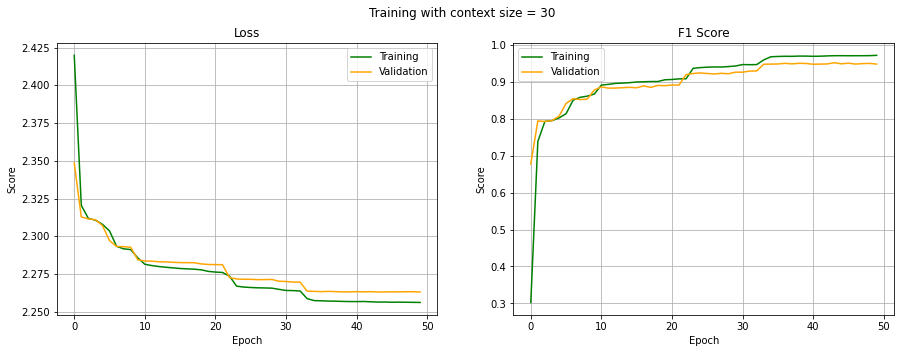

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9721, device='cuda:0'),
 tensor(0.9492, device='cuda:0'),
 tensor(0.9498, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9721, device='cuda:0'),
 tensor(0.9492, device='cuda:0'),
 tensor(0.9498, device='cuda:0'))

## Heatmap

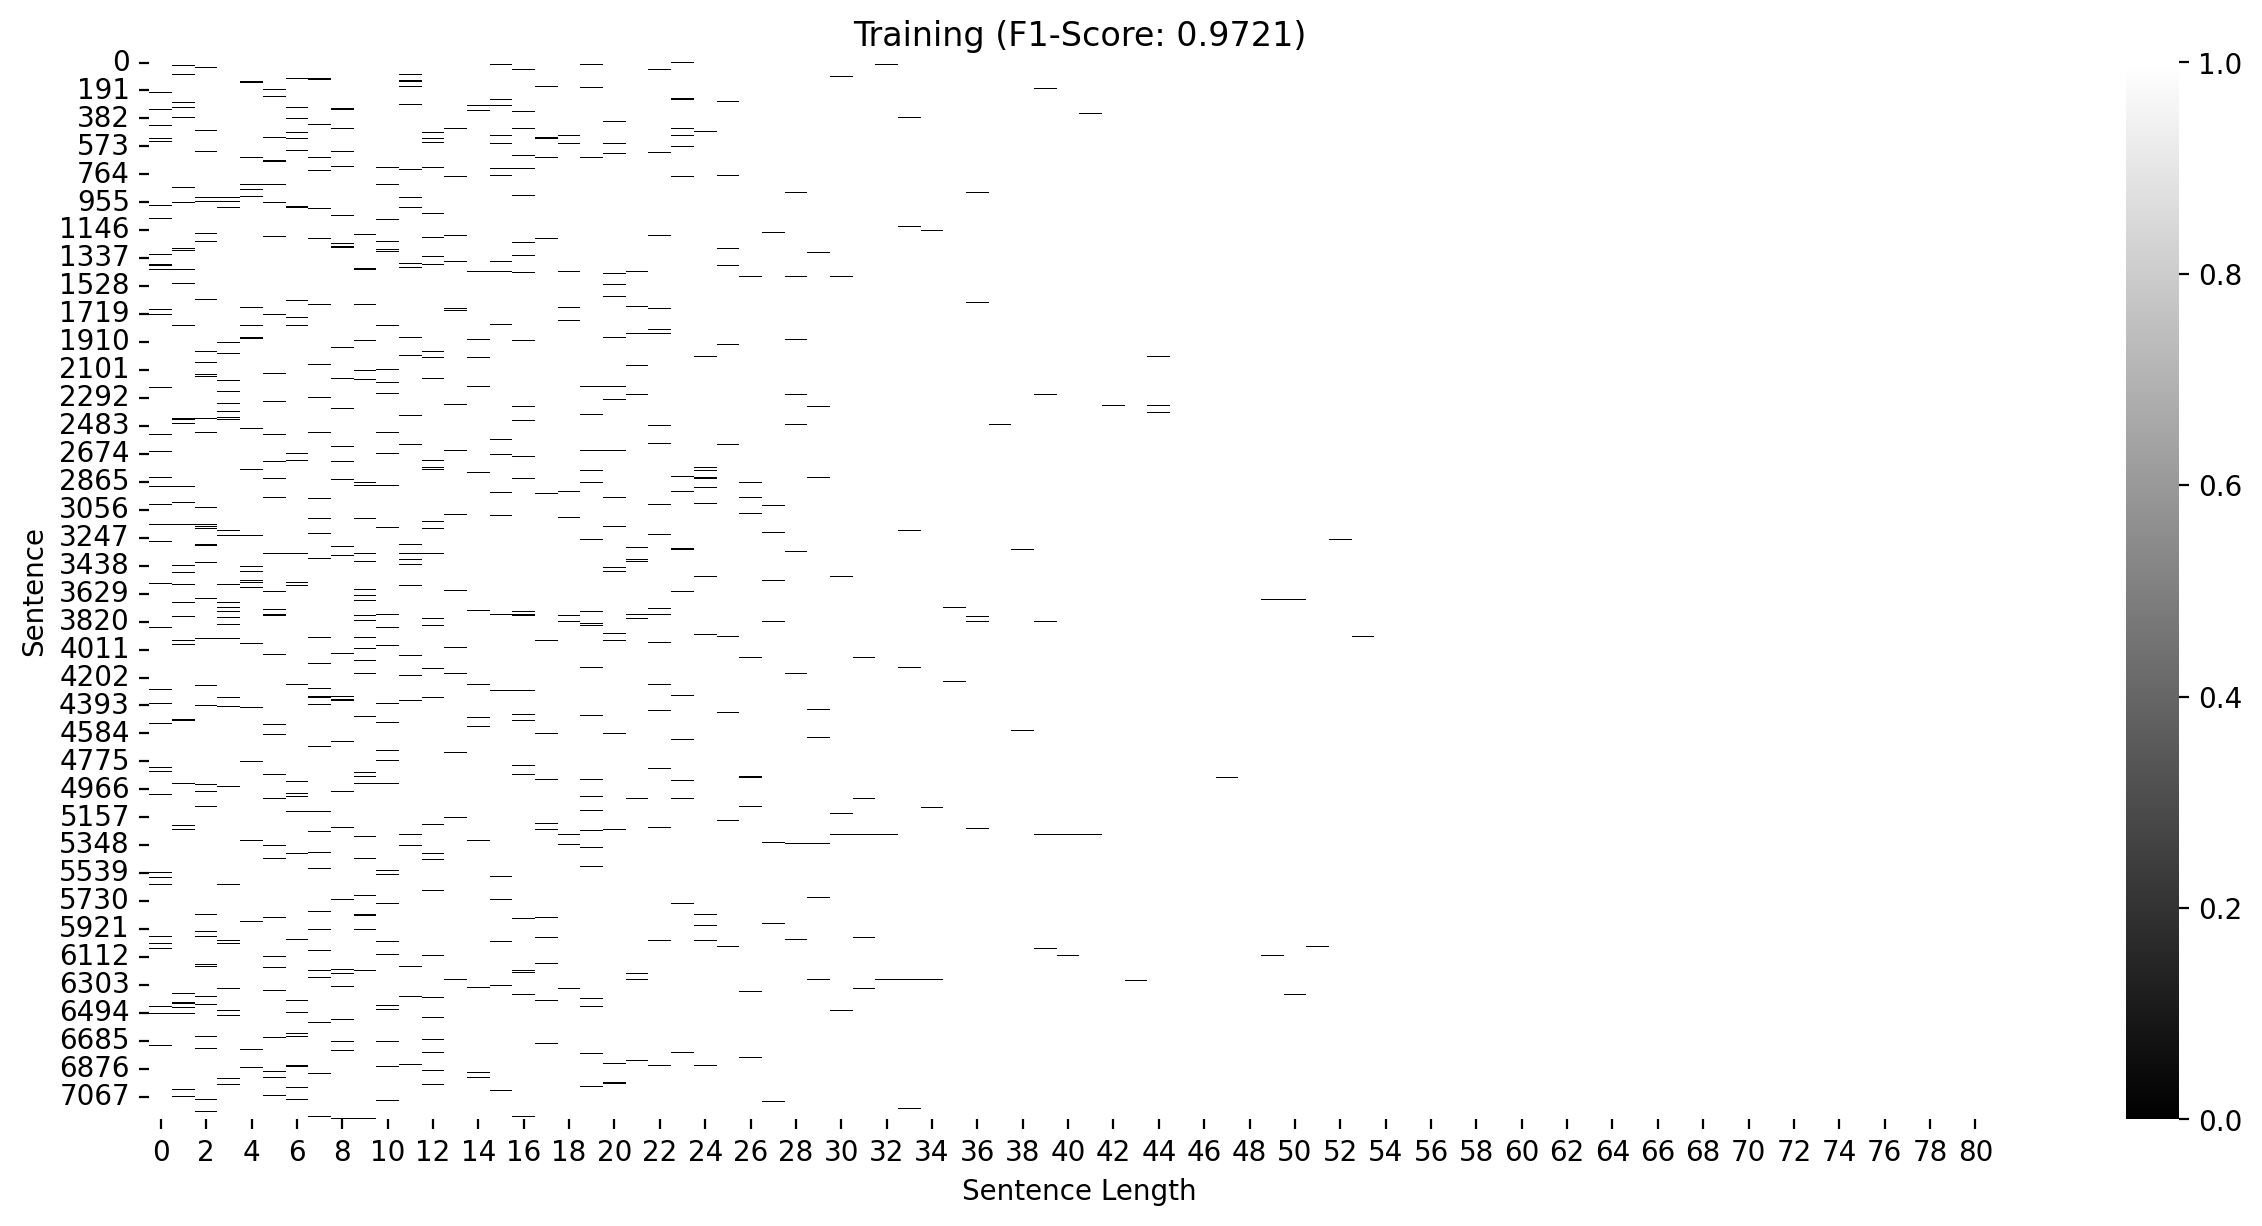

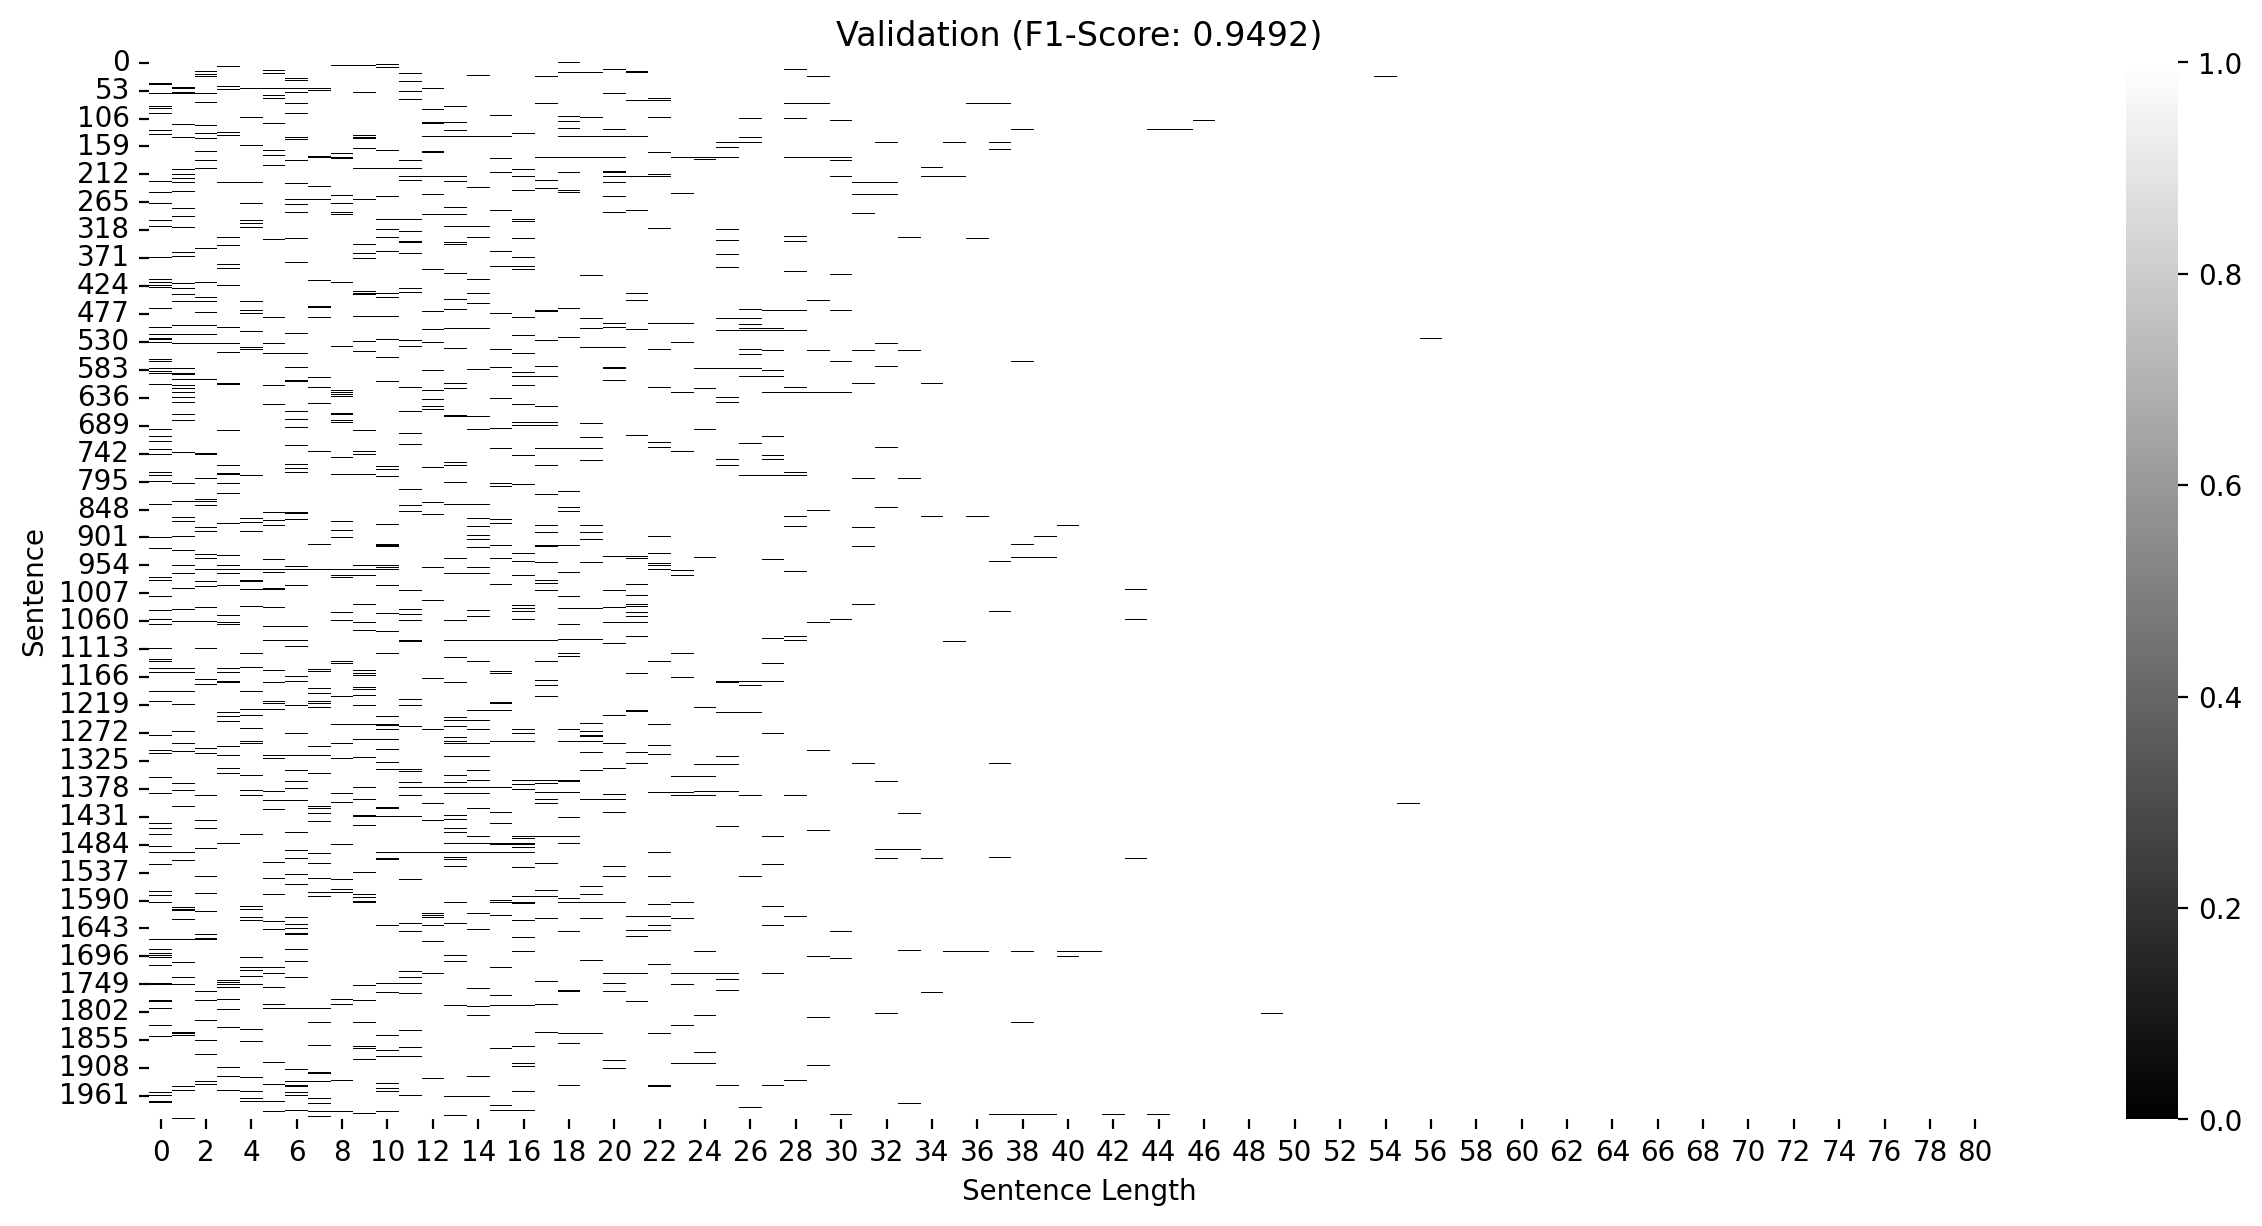

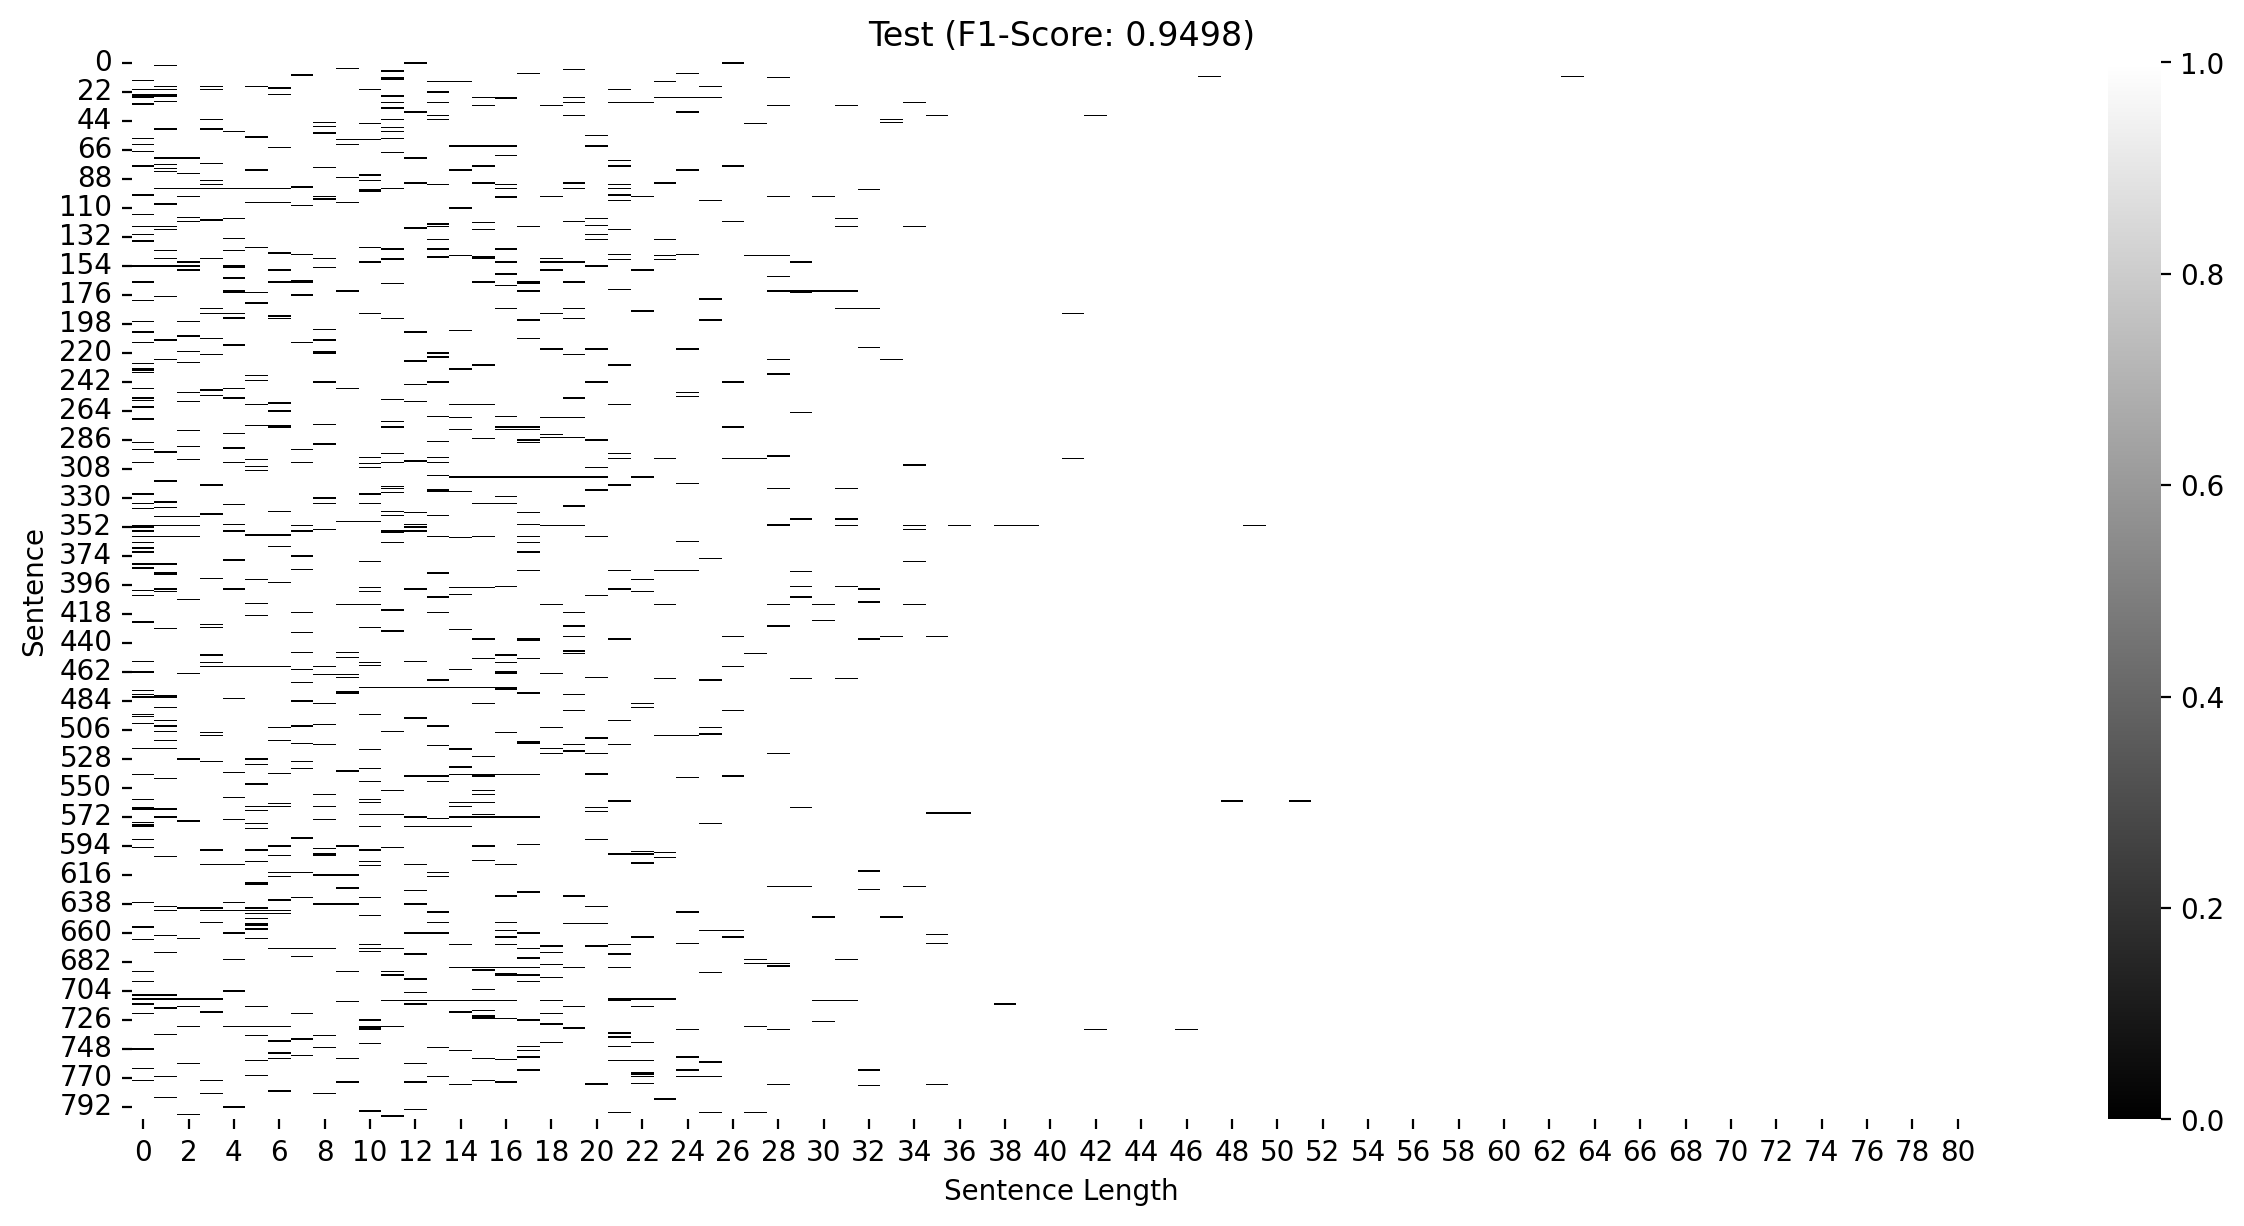

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


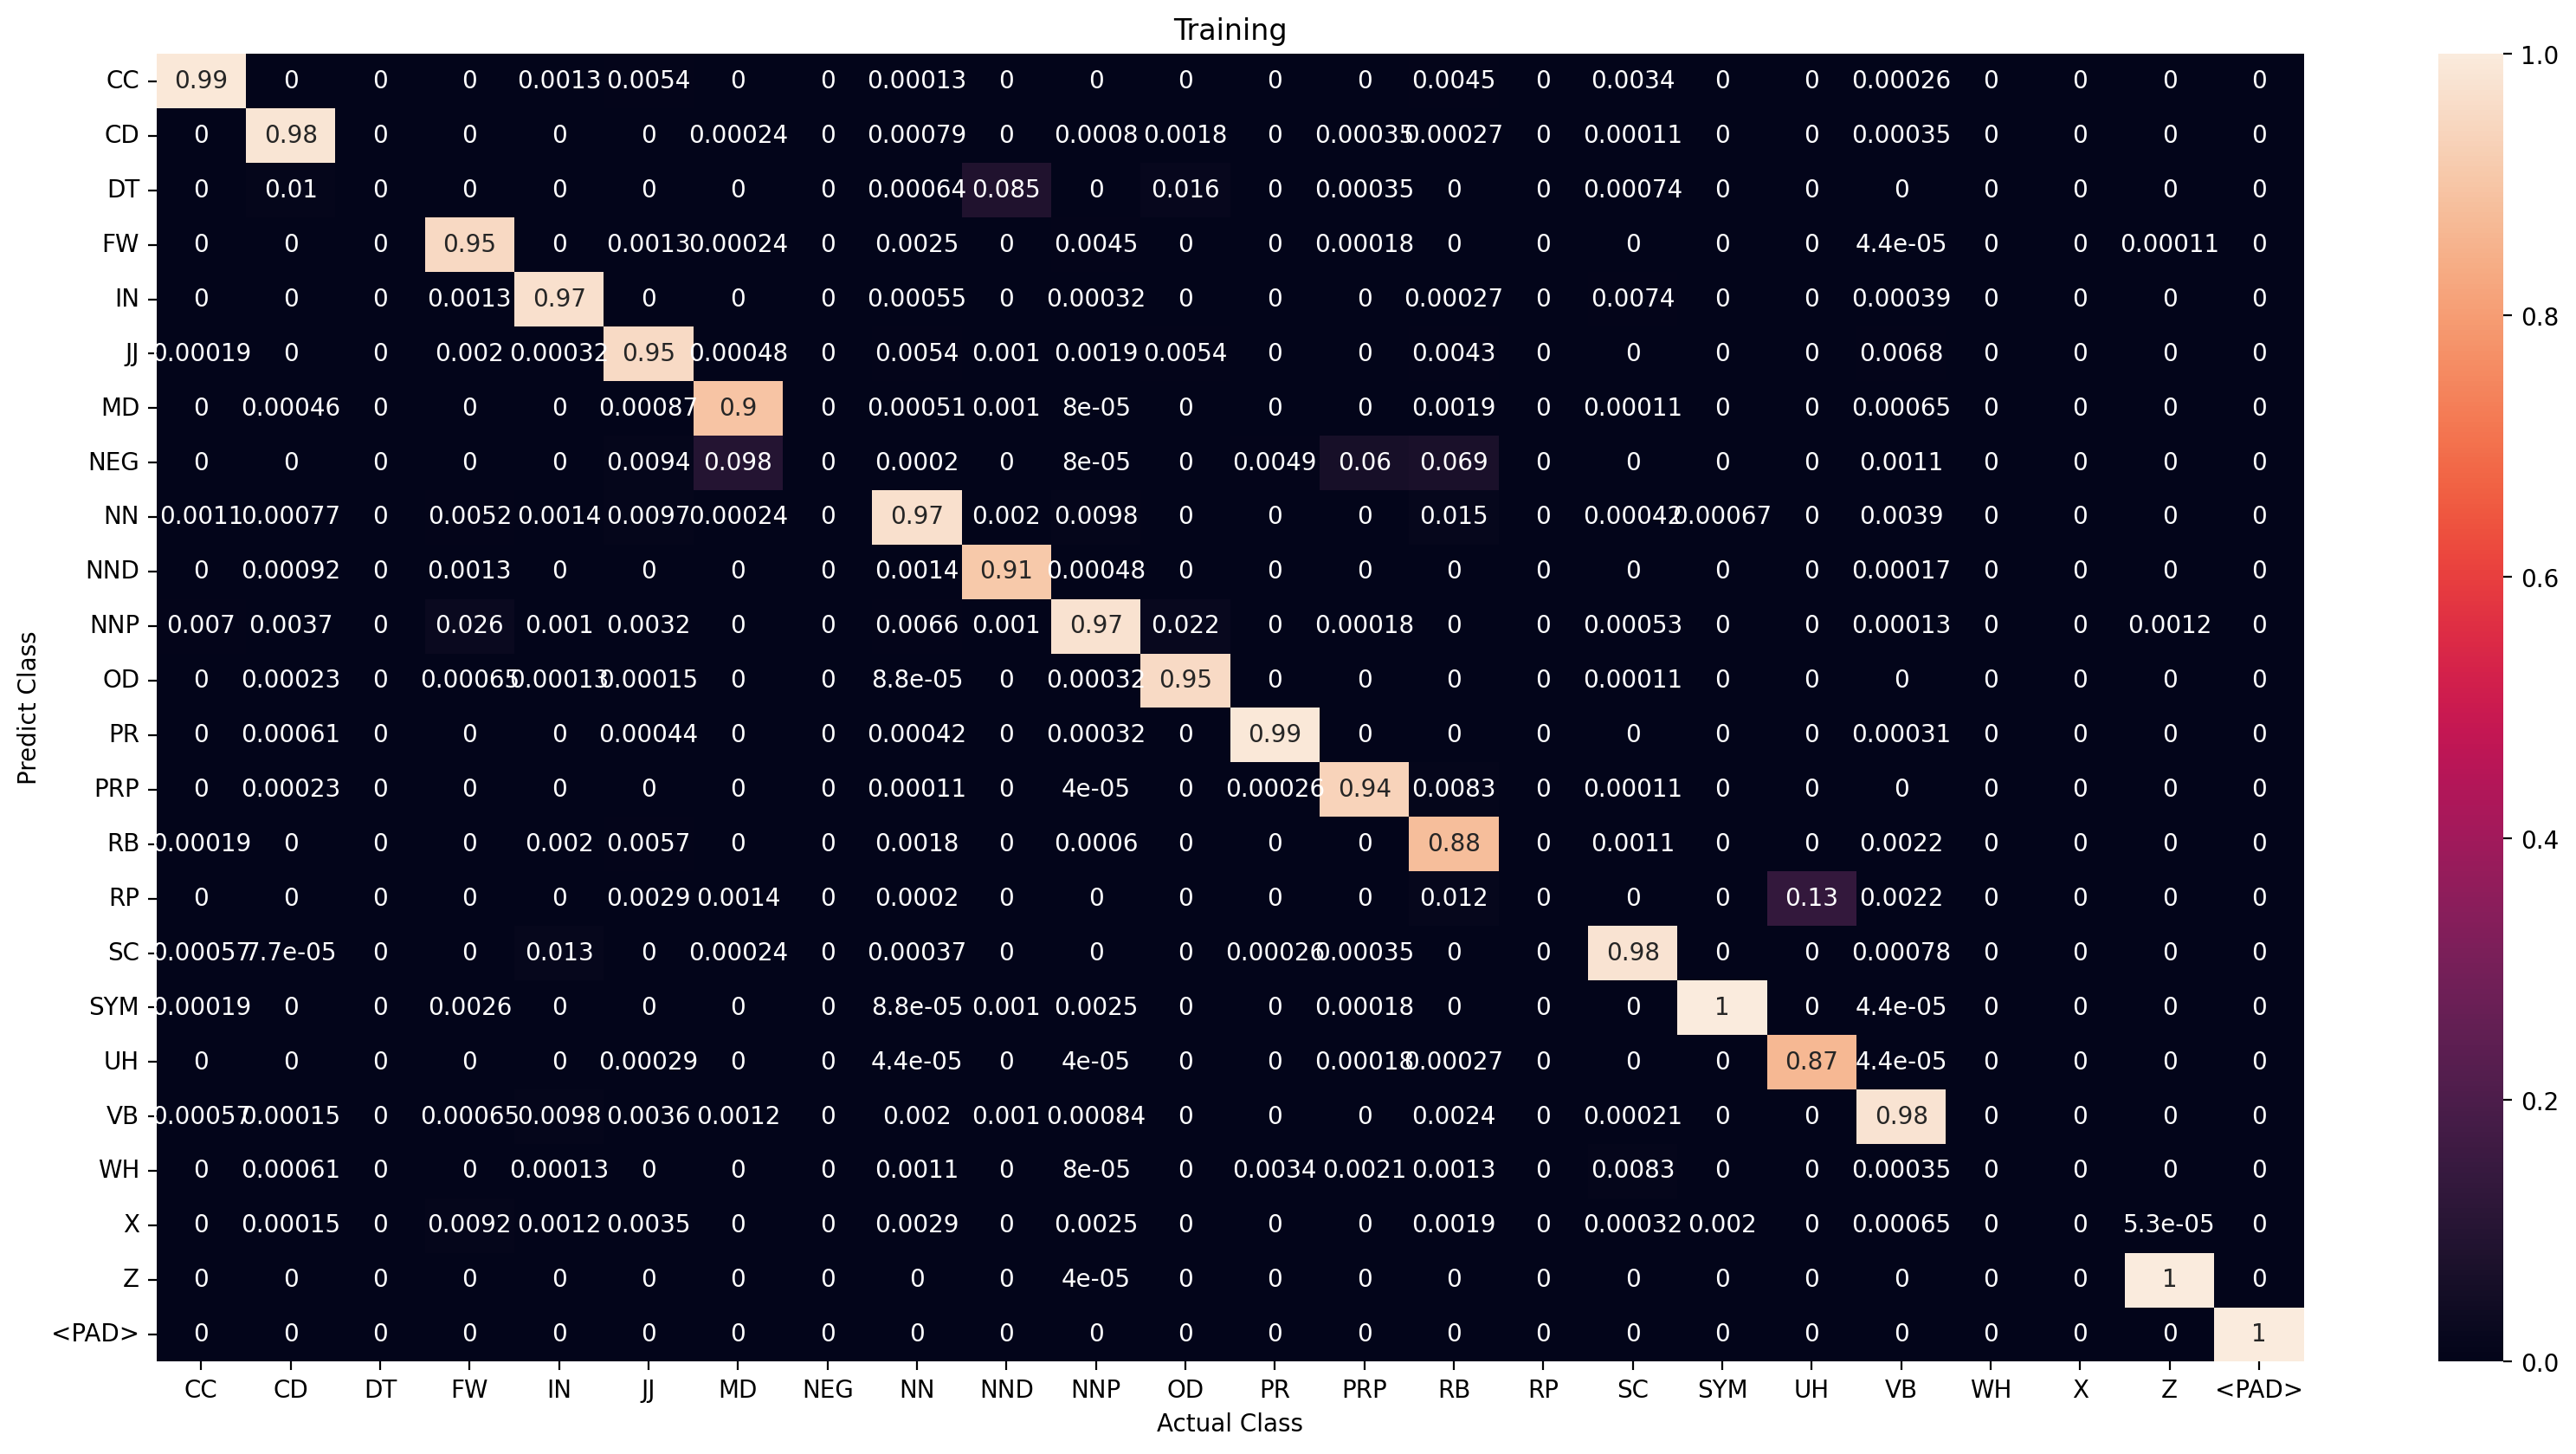

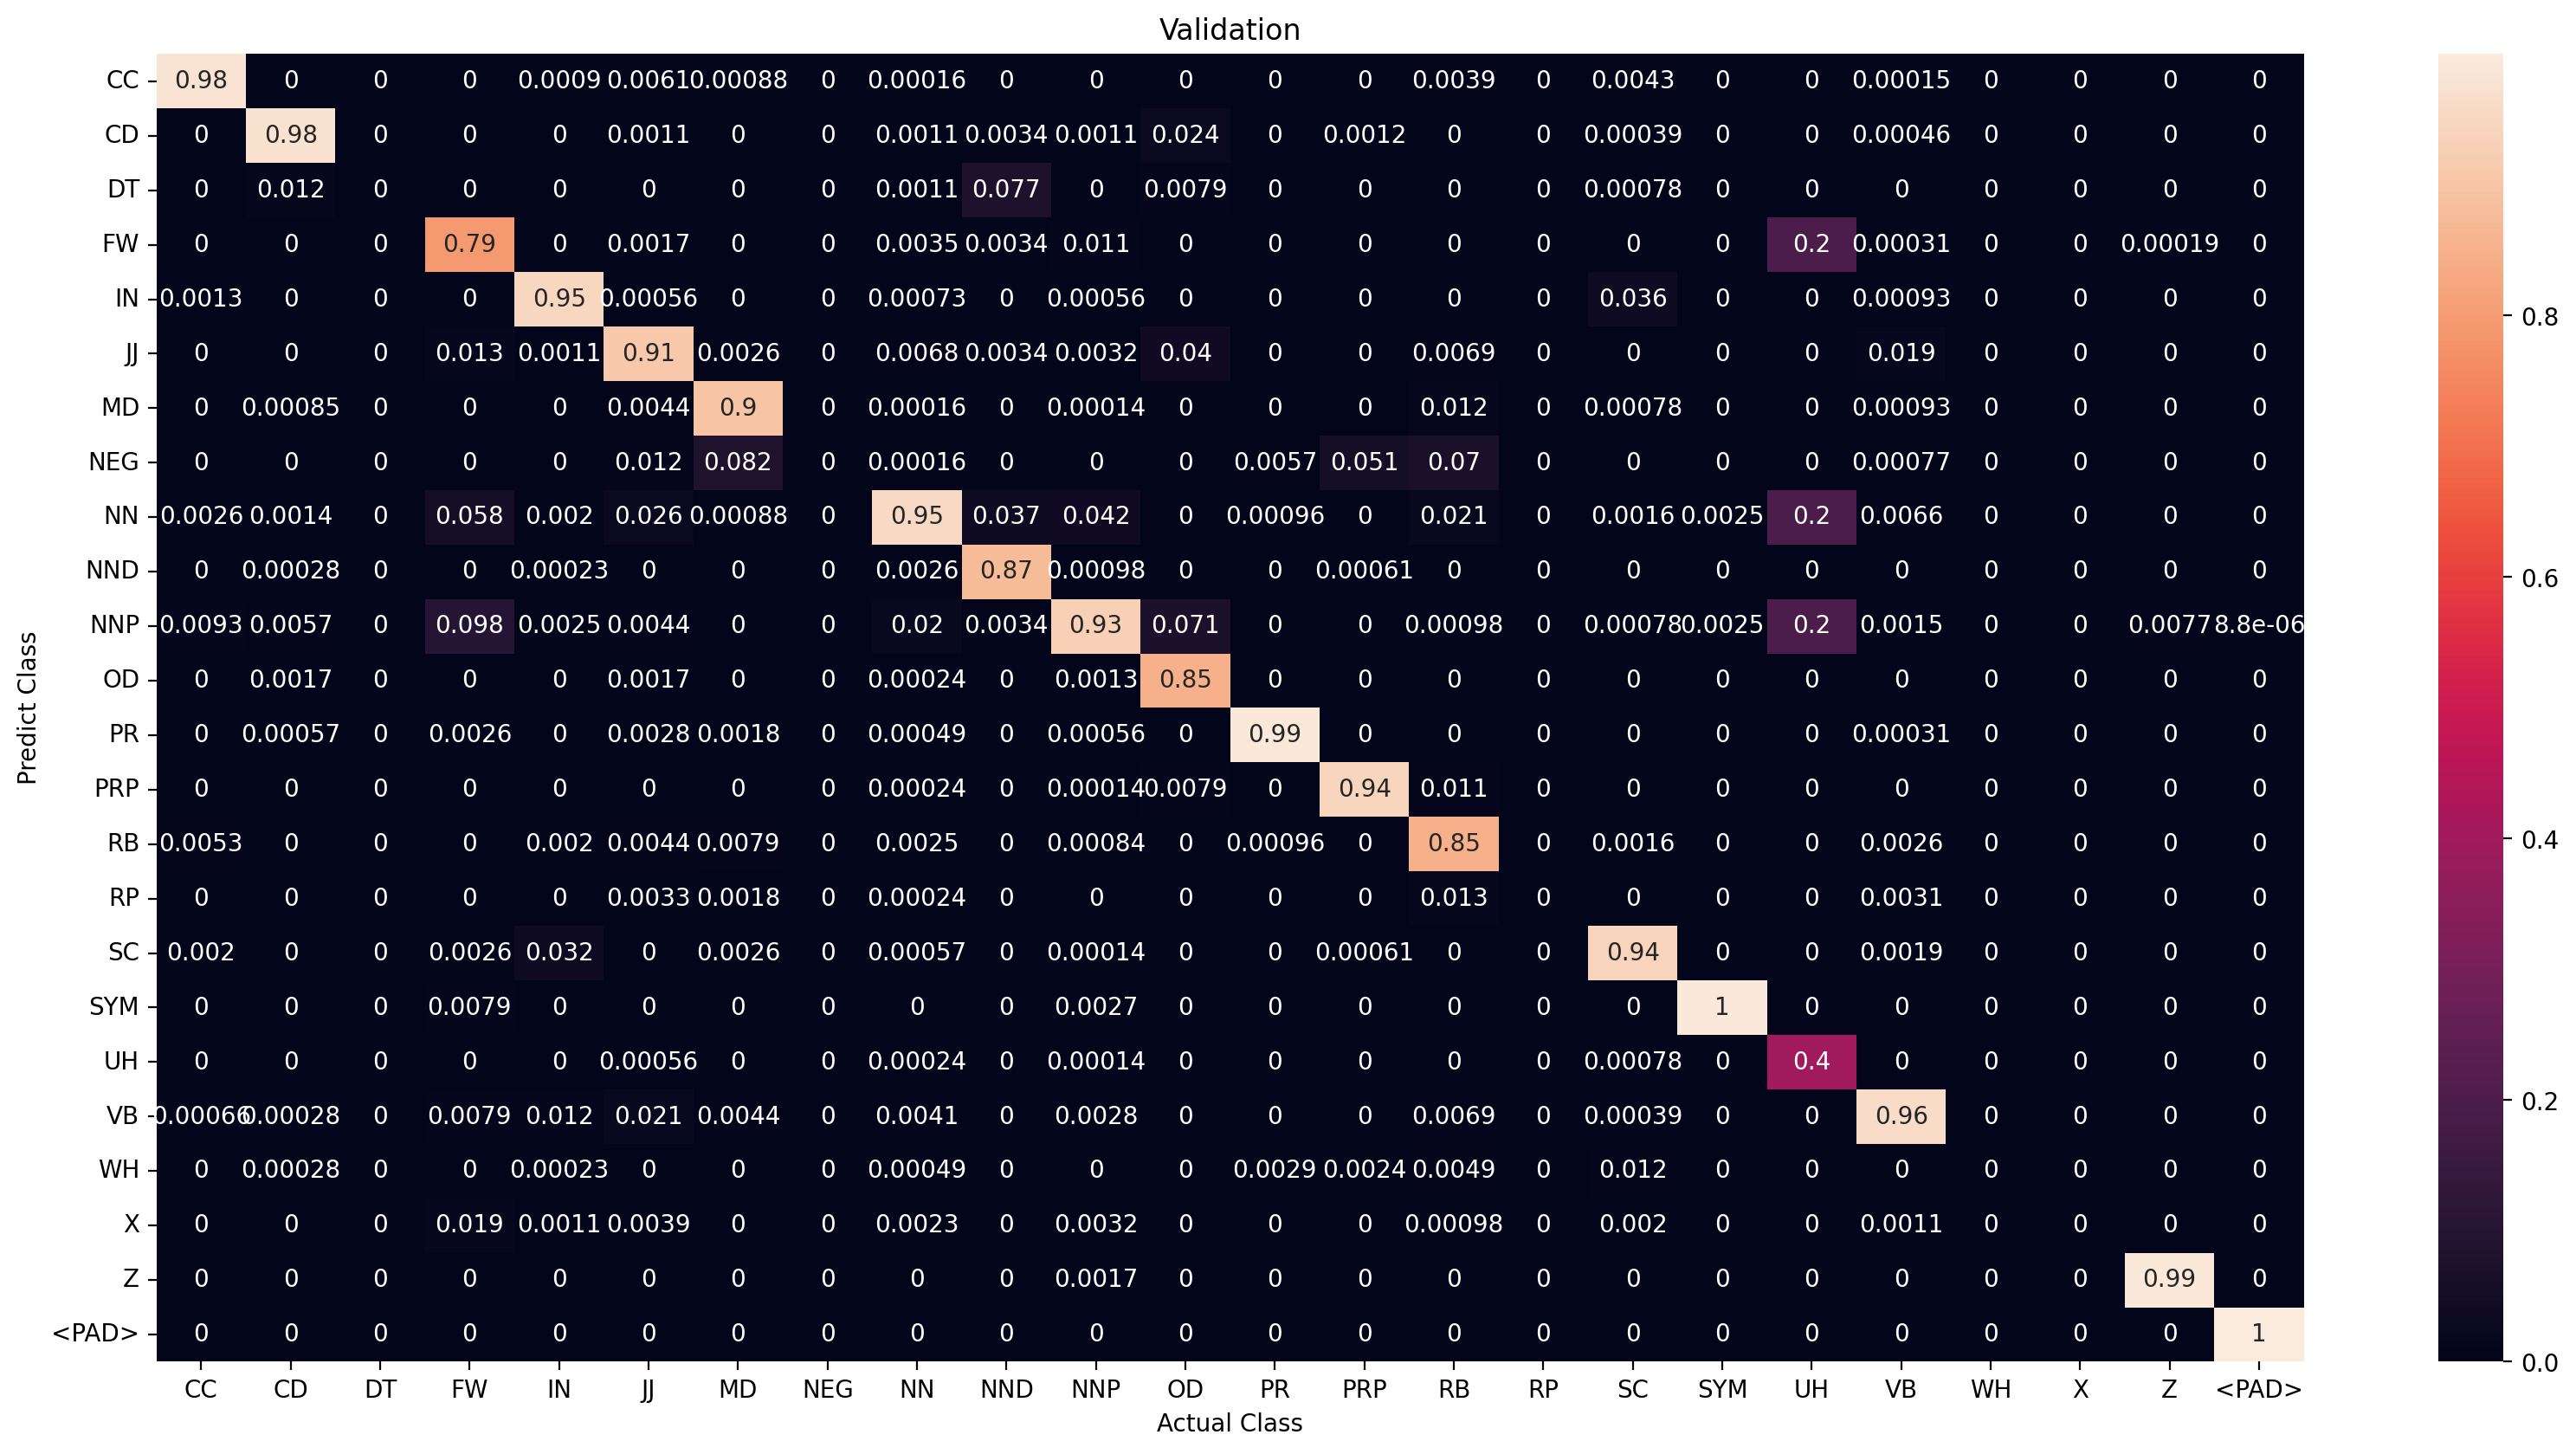

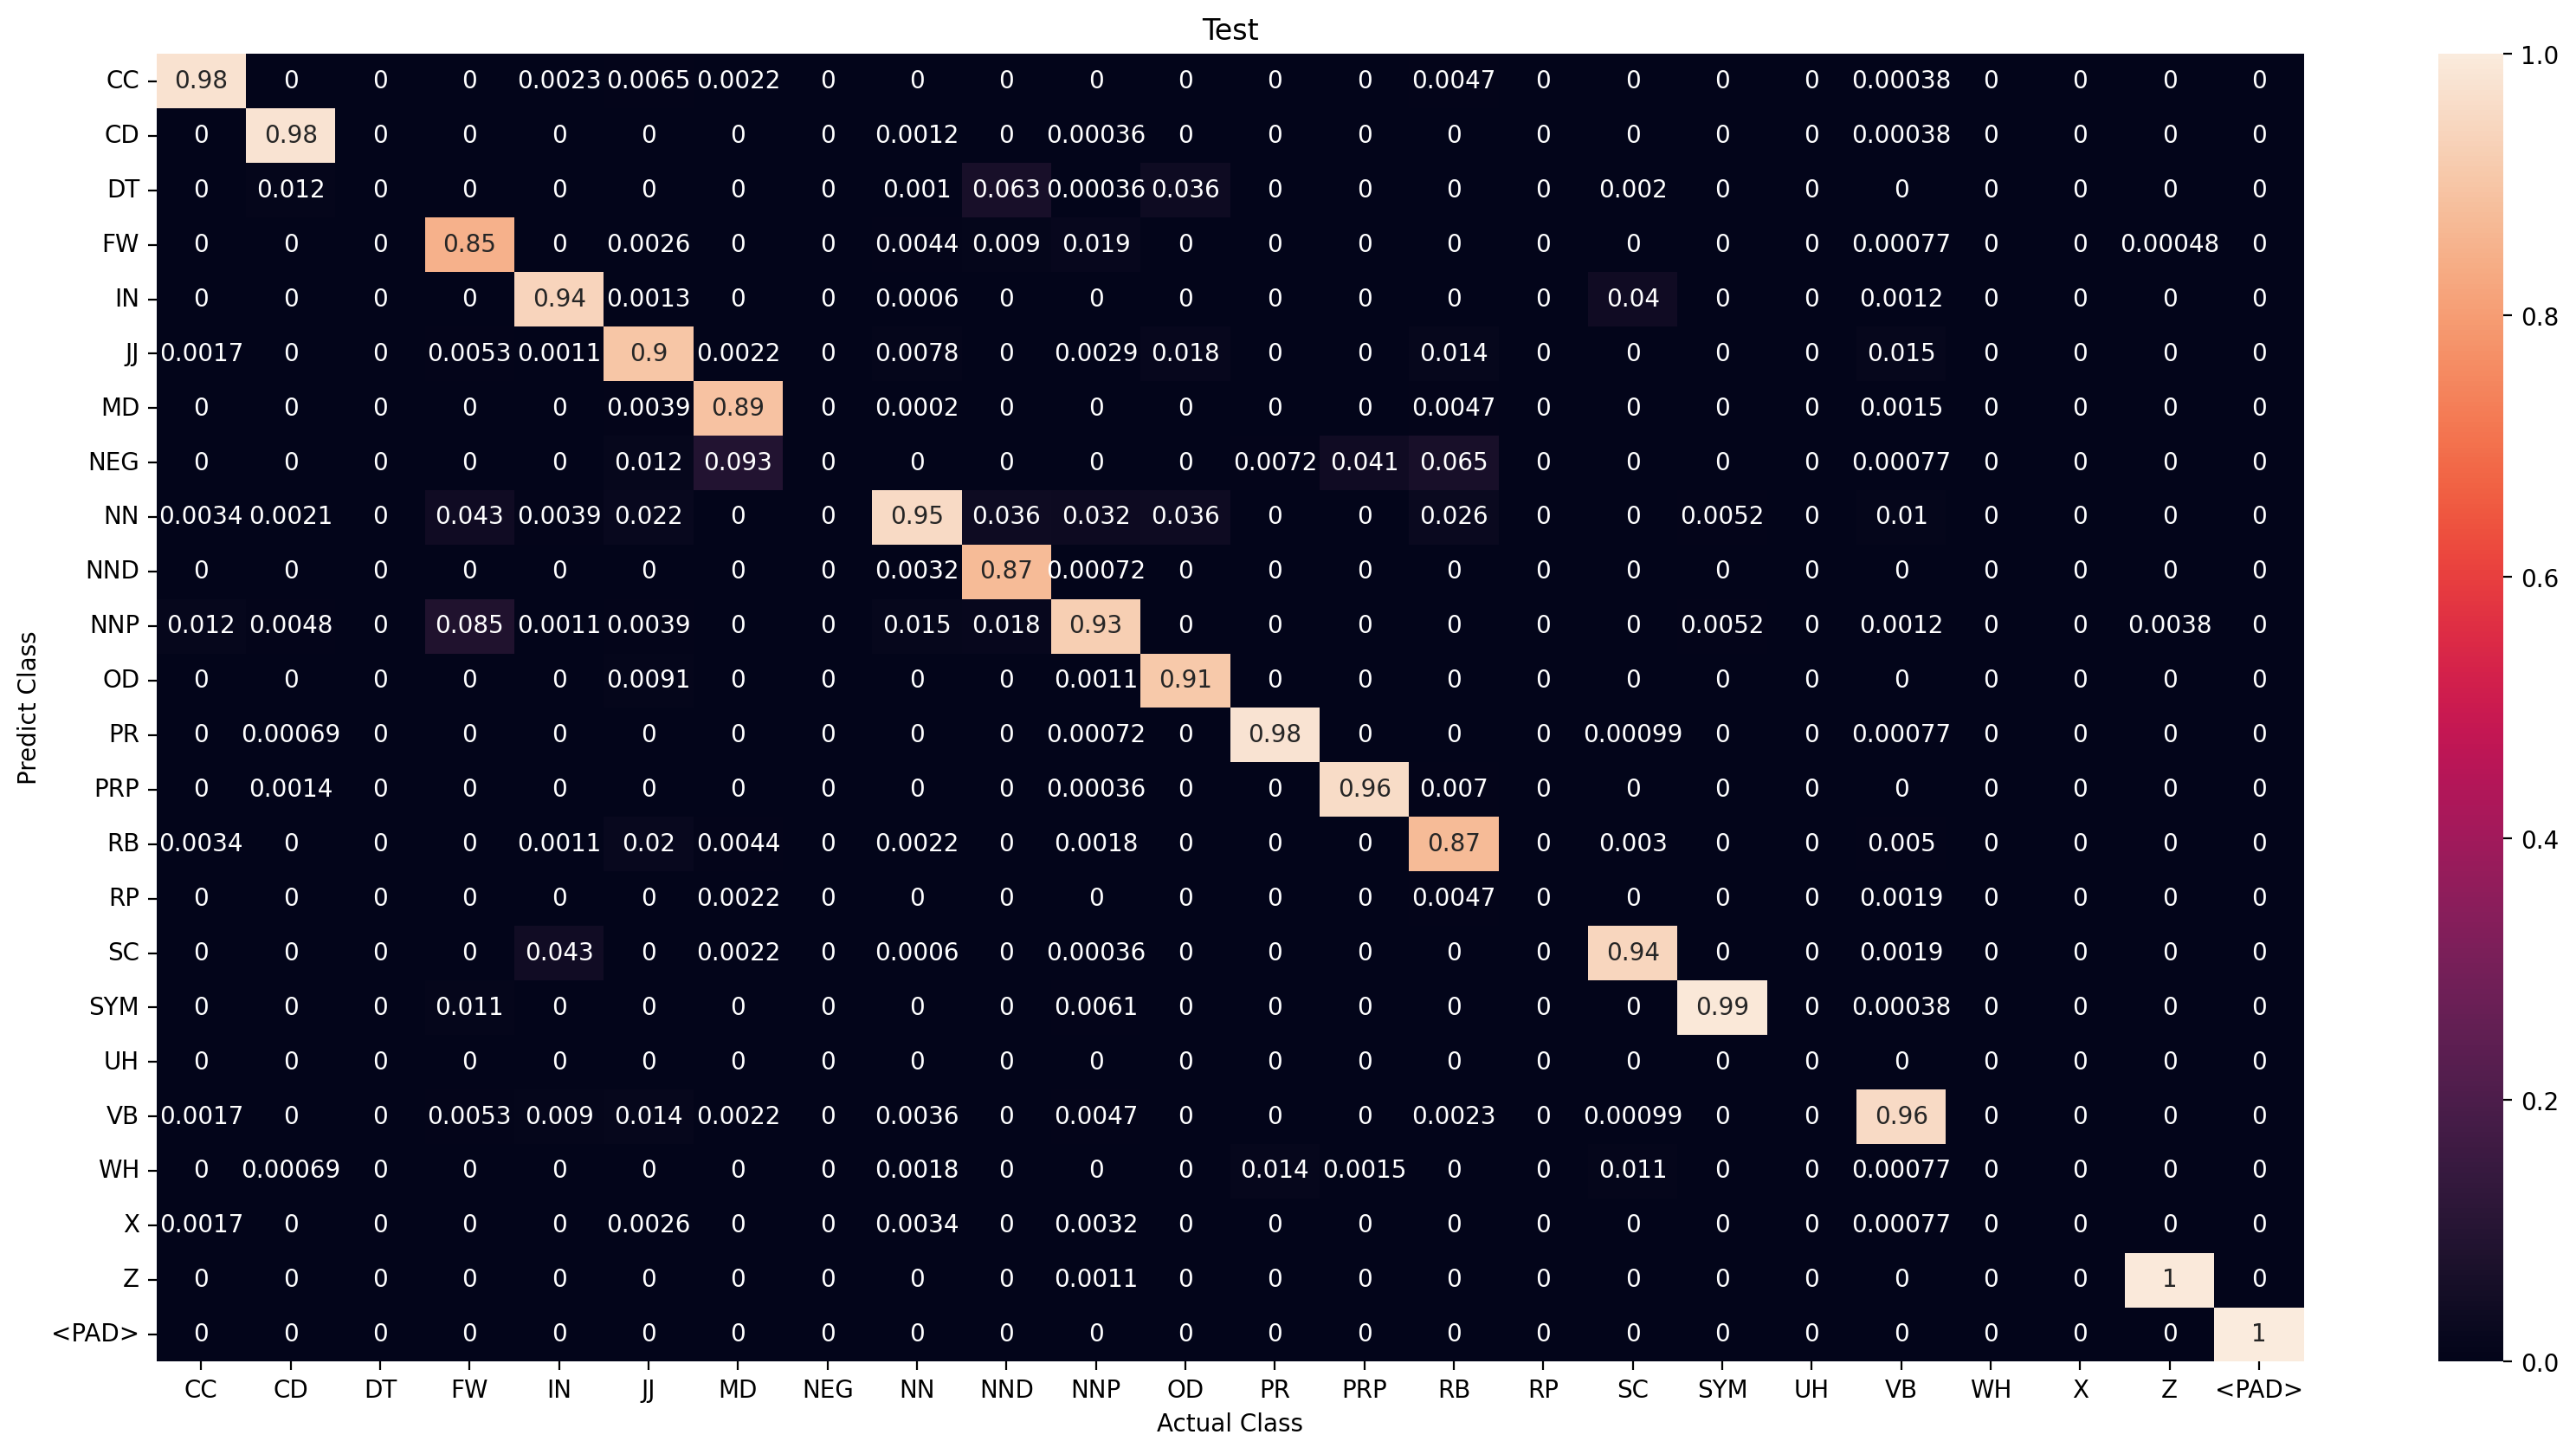

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5336   | CC    : 5218       | CC    : 118      |
| CD    : 12904  | CD    : 12834      | CD    : 70       |
| DT    : 263    | DT    : 0          | DT    : 263      |
| FW    : 1697   | FW    : 1455       | FW    : 242      |
| IN    : 15290  | IN    : 15175      | IN    : 115      |
| JJ    : 7049   | JJ    : 6571       | JJ    : 478      |
| MD    : 3783   | MD    : 3722       | MD    : 61       |
| NEG   : 1126   | NEG   : 0          | NEG   : 1126     |
| NN    : 44769  | NN    : 44260      | NN    : 509      |
| NND   : 998    | NND   : 905        | NND   : 93       |
| NNP   : 24884  | NNP   : 24376      | NNP   : 508      |
| OD    : 550    | OD    : 530        | OD    : 20       |
| PR    : 3878   | PR    : 3833       | PR    : 45       |
| PRP   : 5355   | PRP   : 5313       | PRP   : 42       |
| RB    : 3517   | RB    : 3289       | RB    : 228      |
| RP    : 131    | RP    : 0          | RP    : 131     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11934
Correct prediction          : 11217
Wrong prediction            : 717
Percentage correct oov pred : 93.99195575666164

Validation
Number OOV token            : 3261
Correct prediction          : 2942
Wrong prediction            : 319
Percentage correct oov pred : 90.21772462434836

Test
Number OOV token            : 1367
Correct prediction          : 1223
Wrong prediction            : 144
Percentage correct oov pred : 89.4659839063643



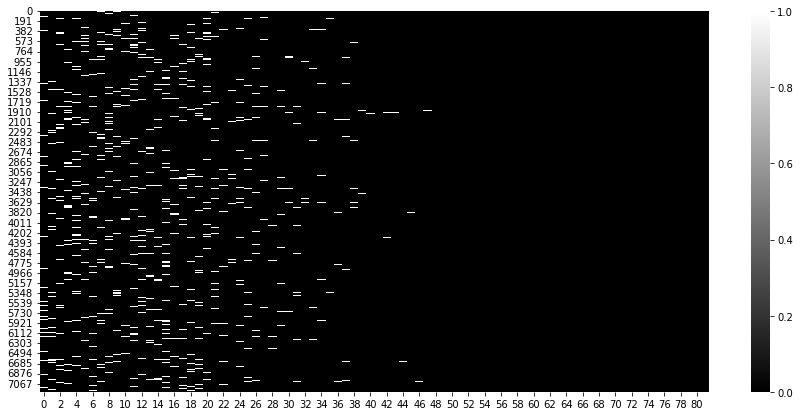

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

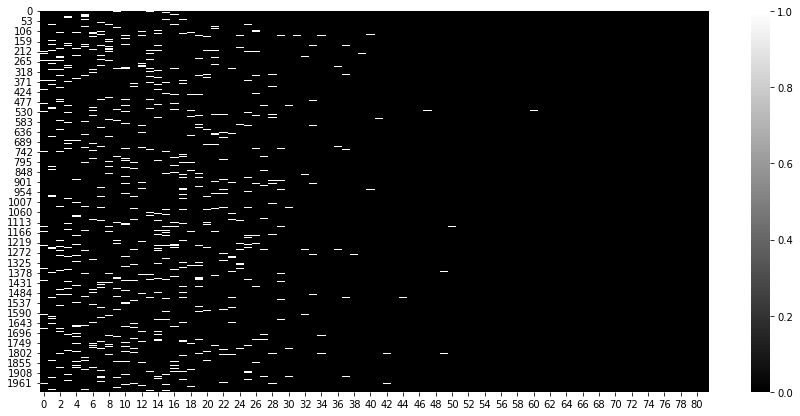

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

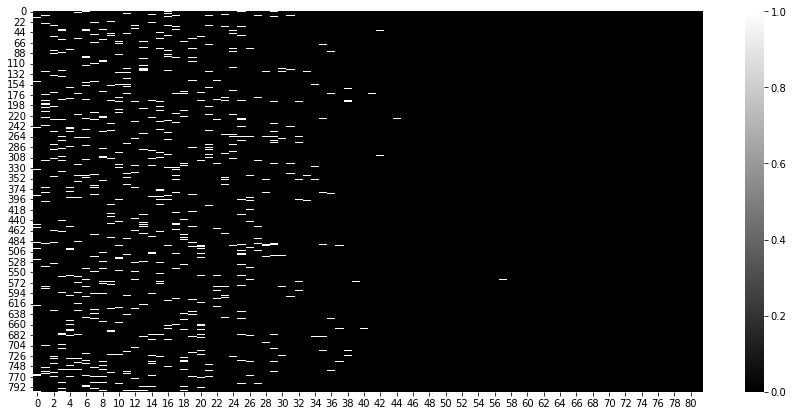

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);